# Executive Summary

In Part 1 of culture and corruption, the cultural dimension which showed the most correlation with corruption levels was power distance. In Part 2, a linear regression model is built from scratch to show how the model works and then SkLearn's linear regression model is used to show how different methods for handling missing values can have a strong impact on the effectiveness of the model. A boxplot of the coefficient of determination from 500 iterations of linear regression for each method is created. Insights are as follows:

- Using the column mean has the worst performance overall.
- Using linear interpolation, outliers or dropping missing values had the same mean value.
- Dropping the values altogether had the highest potential value.

# Introduction

In part 1, power distance was shown to have the strongest correlation with corruption. Part 2 will consist of a walkthrough of how linear regression works and a comparison of the impact of different methods. Please follow the links for explanations of Hofstede's cultural dimensions and how the CPI corruption index is created. How linear regression works and how the coefficient of determination is calculated will also be shown. 

# Set up

In [2]:
import pandas as pd
import numpy as np
import missingno as msno
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import pickle
from statistics import mean
import matplotlib.pyplot as plt
import seaborn as sns

#style setting

sns.set_style("whitegrid")
plt.style.use('seaborn-whitegrid')
al = 0.8
cls = ['red', 'darkgrey', 'forestgreen', 'royalblue', 'indigo']
linecl = 'black'
PDi = 'Power Distance'
CPI = 'CPI Corruption Index'
CoD = 'Coefficient of Determination'

The dataset from part 1 will be imported and all columns aside fom power_distance and CPI_score_2019 will be dropped.

In [3]:
#Dataframe from the end of part 1

infile = open('df','rb')
df = pickle.load(infile)
infile.close()
df

,country,power_distance,individualism,masculinity,uncertainty_avoidance,long_term_orientation,indulgence,region,CPI_score_2019,bertelsmann_foundation_trans,economist_intel_unit,global_insight_country_risk,PRS_int_country_risk,varieties_of_democracy_project,world_economic_forum_EOS,world_justice_project_rule_of_law,region_num
0,Africa East,64.0,27.0,41.0,52.0,32.000000,40.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Africa West,77.0,20.0,46.0,54.0,9.000000,78.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Albania,NaN,NaN,NaN,NaN,61.460957,14.508929,ECA,35.0,37.0,37.0,35.0,41.0,20.0,37.0,28.0,4.0
3,Algeria,NaN,NaN,NaN,NaN,25.944584,32.366071,MENA,35.0,37.0,37.0,35.0,32.0,23.0,46.0,36.0,5.0
4,Andorra,NaN,NaN,NaN,NaN,NaN,65.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106,Uruguay,61.0,36.0,38.0,100.0,26.196474,53.348214,AME,71.0,77.0,72.0,59.0,76.0,76.0,66.0,72.0,1.0
107,Venezuela,81.0,12.0,73.0,76.0,15.617128,100.000000,AME,16.0,9.0,20.0,10.0,15.0,25.0,16.0,13.0,1.0
108,Vietnam,70.0,20.0,40.0,30.0,57.178841,35.491071,AP,37.0,37.0,20.0,47.0,41.0,42.0,40.0,34.0,2.0
109,Zambia,NaN,NaN,NaN,NaN,30.226700,42.187500,SSA,34.0,29.0,37.0,35.0,35.0,43.0,26.0,38.0,0.0


In [4]:
#dropping unnecessary columns
df_base = df.copy()
df_base.drop(['country', 'region','bertelsmann_foundation_trans', 'economist_intel_unit', 'global_insight_country_risk', 'PRS_int_country_risk', 'varieties_of_democracy_project', 'world_economic_forum_EOS', 'world_justice_project_rule_of_law', 'region_num', 'masculinity', 'indulgence', 'individualism', 'uncertainty_avoidance', 'long_term_orientation'], axis=1, inplace=True)


Power distance is missing a lot of values, meaning that how they are handled will have a sizeable effect on the accuracy of the final model.

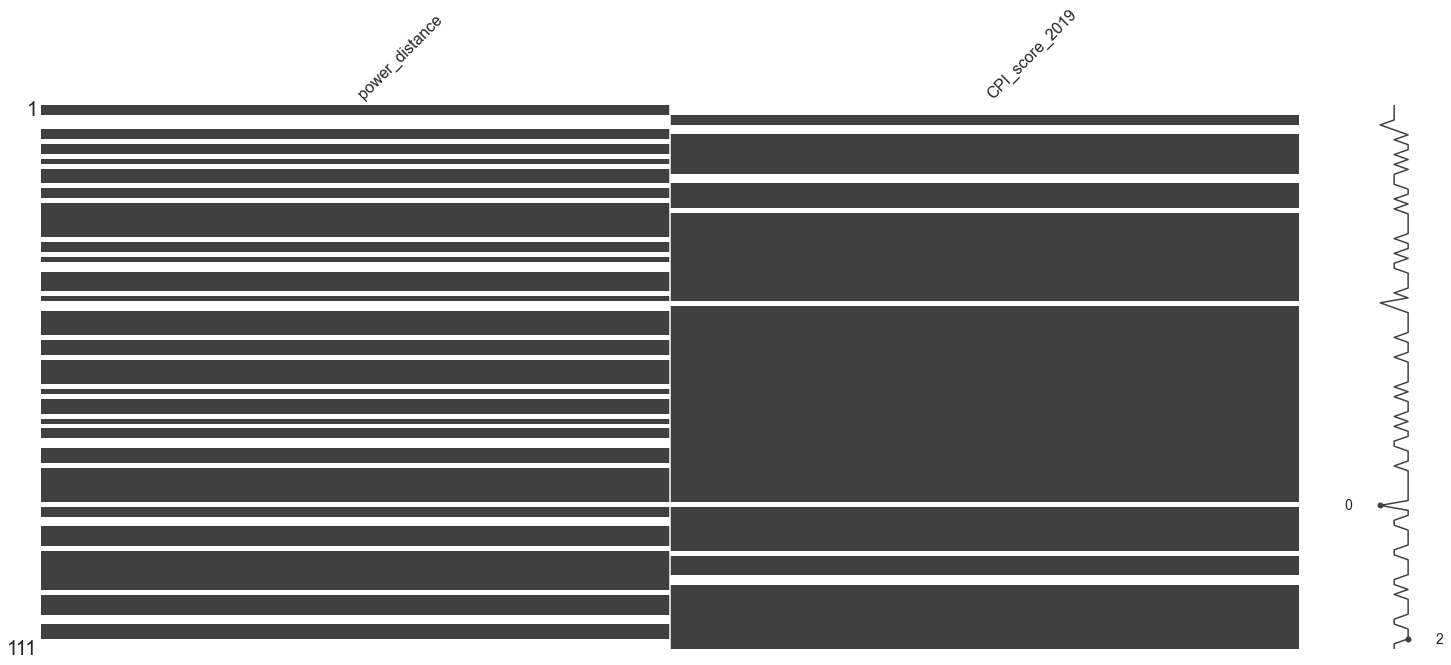

In [5]:
msno.matrix(df_base)

# Feature Engineering

Firstly, datasets for each method will be created. Secondly, the "mean" dataset will be prepared to be used for the linear regression walkthrough. This differs from how SKlearn requires the data to be processed and so other methods will be ignored for the time being.

In [6]:
df_base = shuffle(df_base)
df_mean = df_base.copy()
df_linear = df_base.copy()
df_drop = df_base.copy()
df_out = df_base.copy()

df_mean['power_distance'].fillna(df_base['power_distance'].mean(), inplace=True)
df_linear['power_distance'].interpolate()
df_out['power_distance'].replace(np.nan, -999999)

df_mean.dropna(axis=0, how='any', inplace=True)
df_linear.dropna(axis=0, how='any', inplace=True)
df_drop.dropna(axis=0, how='any', inplace=True)
df_out.dropna(axis=0, how='any', inplace=True)


In [7]:
#data splitting

X = np.array(df_mean['power_distance'].values.tolist())
y = np.array(df_mean['CPI_score_2019'].values.tolist())
X = np.array(X,dtype = float)
#X = X.transpose()
X_train, X_test, y_train, y_test = train_test_split(X, y)


# Models

This section has three parts.

1. An overview of the maths for how a regression line is created and the coefficient of determination is calculated is given.
2. This is shown in code with visualisations.
3. SkLearn is used to show how much of an impact the dataset selection can have.

## Linear regression and the coefficient of determination

The basic formula for finding the regression line is y = mx + b. m is calculated from means of x and y and is the angle of the regression line. b (also known as the intercept) is where the line crosses the x value of 0. y (the value we went to predict) is equal to the m  times by x, plus b. 

The coefficient of determination is the square of the correlation between predicted y scores and actual y scores which normally ranges between 0 and 1, 0 meaning it cannot predict data at all and 1 means it is a perfect predictor. Negative values are possible and indicate that the regression line is a worse predictor than a flat line. 

## Model construction

A basic linear regression model is shown below, followed by a plot of the results.

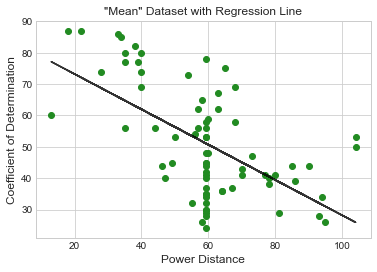

In [8]:
def linear_model(xs, ys):
    #line calculation
    
    m = (( (mean(xs) * mean(ys)) - mean(xs*ys)) /
        ((mean(xs)**2) - mean(xs**2))
       )
    #intercept calculation
    
    b = mean(ys) - m*mean(xs)
    
    return m, b
def model_and_line(X_train, y_train):
    
    
    
    m, b =linear_model(X_train, y_train)

    regression_line = [(m*x)+b for x in X_train]
    
    return m, b, regression_line

m, b, regression_line = model_and_line(X_train, y_train)

#chart

plt.title('"Mean" Dataset with Regression Line')
plt.scatter(X_train, y_train, color=cls[2])
plt.ylabel(CoD, size=12)
plt.xlabel(PDi, size=12)
plt.plot(X_train,regression_line, color=linecl, alpha=al)




To evaluate how well the regression line performs, the coefficient of determination will be calculated. This will require the use of three functions: squared_error(), coefficient_of_determination() and model_eval().
model_eval() takes the data, runs the model_and_line() function above. The regression line this generates and the y values are then used in coefficient_of_determination() to generate the r^2 of the regression line, using squared_error() to calculate some of the values. This will be done using the mean dataset to calculate how effective and this is plotted below.

In [11]:
def squared_error(ys_orig, ys_line):
    return sum((ys_line-ys_orig) **2)
def coefficient_of_determination(ys_orig, ys_line):
    y_mean_line = [mean(ys_orig) for y in ys_orig]
    squared_error_regr = squared_error(ys_orig, ys_line)
    squared_error_y_mean = squared_error(ys_orig, y_mean_line)
    return 1 - (squared_error_regr / squared_error_y_mean)
    
r_squared = coefficient_of_determination(y_train, regression_line)


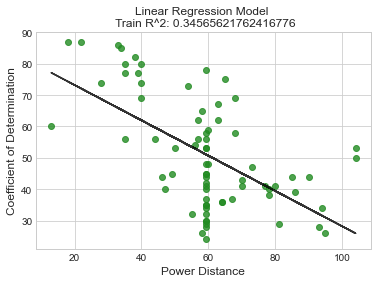

In [12]:


def model_eval(X_train,y_train):
    
    m, b, regression_line = model_and_line(X_train, y_train)    
    r_squared = coefficient_of_determination(y_train, regression_line)
    
    return r_squared, regression_line, b, m
r_squared, regression_line, b, m=model_eval(X_train,y_train)

plt.title(f'Linear Regression Model \n Train R^2: {r_squared}')
plt.plot(X_train,regression_line, color=linecl, alpha=al)
plt.ylabel(CoD, size=12)
plt.xlabel(PDi, size=12)
plt.scatter(X_train, y_train, color=cls[2], alpha=al)

A result of 0.327 is not particularly high but it's likely this could be improved. Predictions will now be made using this model.

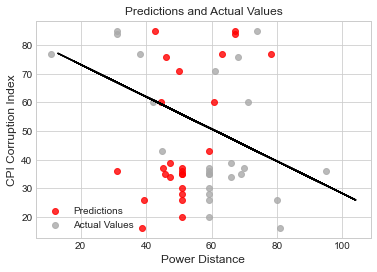

In [13]:
def predict(X_test, m, b):
    preds=[]

    for i in range(len(X_test)):
        predict = (m*X_test[i])+b
        preds.append(predict)
    
    
    
    return preds

predictions= predict(X_test, m, b)

plt.title(f'Predictions and Actual Values')
plt.scatter(predictions, y_test, color=cls[0], label='Predictions', alpha=al)
plt.scatter(X_test, y_test, color=cls[1], label='Actual Values', alpha=al)
plt.ylabel(CPI, size=12)
plt.xlabel(PDi, size=12)
plt.plot(X_train, regression_line, color=linecl)
plt.legend()
plt.savefig('LinRegLin.png')

The predictions are, for the most part, fairly close to the acutal values but the impact of the mean values can be clearly seen.

## Model comparison

For the final stage, all of the different datasets will be used with SkLearn's Linear Regression model and then the coefficient of determination will be calculated. This will be repeated 500 times to give an indication of which dataset performs the best in general. This will use several different functions.

splitter() separates the values into 'X'(features) and 'y'(values to be predicted) and then passes the values to data_processor(). In the data_processor() function, the data is shuffled, converted to a data type SkLearn can use, reshaped and then split. This is returned to splitter() which returns the results from data_processor(). 

In [14]:
def data_processor(X, y):
    X, y = shuffle(X, y)
    X = np.array(X,dtype = float)
    y = np.array(y,dtype = float)
    X = X.reshape(-1, 1)
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
    return X_train, X_test, y_train, y_test

In [15]:
def splitter(df):
    
    X = np.array(df['power_distance'].values.tolist())
    y = np.array(df['CPI_score_2019'].values.tolist())
    X_train, X_test, y_train, y_test = data_processor(X, y)

    return X_train, X_test, y_train, y_test 


Because this process returns a randomly shuffled dataset, the data points the model uses will be different each time, as shown below.

Text(0.5, 1.0, 'Handling Missing Values: Data Point Comparison')

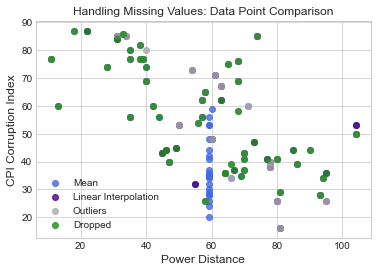

In [18]:
X_train_m, X_test_m, y_train_m, y_test_m = splitter(df_mean)
X_train_l, X_test_l, y_train_l, y_test_l = splitter(df_linear)
X_train_o, X_test_o, y_train_o, y_test_o = splitter(df_out)
X_train_d, X_test_d, y_train_d, y_test_d = splitter(df_drop)

plt.scatter(X_train_m, y_train_m, color=cls[3], label='Mean', alpha=al)
plt.scatter(X_train_l, y_train_l, color=cls[4], label='Linear Interpolation', alpha=al)
plt.scatter(X_train_o, y_train_o, color=cls[1], label='Outliers', alpha=al)
plt.scatter(X_train_d, y_train_d, color=cls[2], label='Dropped', alpha=al)
plt.ylabel(CPI, size=12)
plt.xlabel(PDi, size=12)
plt.legend()
plt.title('Handling Missing Values: Data Point Comparison')

The model_evaluator() runs the functions above and then uses SkLearn's function for making predictions and calculating the coefficient of determination. Finally, all of the coefficients are returned. 

In [23]:
def model_evaluator(df, iters):
    coefficients=[]
    for i in range(iters):
        X_train, X_test, y_train, y_test = splitter(df)
        clf = LinearRegression()
        clf.fit(X_train, y_train)
        predictions = clf.predict(X_test)
        coefficient = r2_score(y_test, predictions)
        coefficients.append(coefficient)
        
    return coefficients

The model_evaluator() function will be run 500 times for each dataset. The results are displayed in the boxplot below.

In [24]:
its = 500
coeffs_m = model_evaluator(df_mean, its)
coeffs_l = model_evaluator(df_linear, its)
coeffs_o = model_evaluator(df_out, its)
coeffs_d = model_evaluator(df_drop, its)

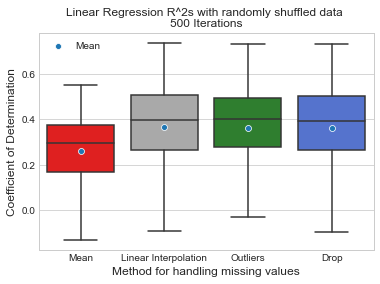

In [25]:
coefficients = [coeffs_m, coeffs_l, coeffs_o, coeffs_d]
coeff_means = [mean(coeffs_m), mean(coeffs_l), mean(coeffs_o), mean(coeffs_d)]

methods =  ['Mean', 'Linear Interpolation', 'Outliers', 'Drop']
ax = sns.boxplot(x=methods, y=coefficients, showfliers=False, palette=cls)
ax = sns.scatterplot(x=methods, y=coeff_means, legend='full', label='Mean')

#lin_coef =mean(coeffs_l)
plt.legend()
plt.xlabel("Method for handling missing values", size=12)
plt.ylabel(CoD, size=12)
plt.title(f"Linear Regression R^2s with randomly shuffled data \n{its} Iterations")
plt.savefig('LinRegBox.png')

Insights:

- Using the column mean has the worst performance overall.
- Using linear interpolation, outliers or dropping missing values had the same mean value.
- Dropping the values altogether had the highest potential value.
- Using linear inpolation, outliers, or dropping them altogether all had fairly similar values.

# Conclusion

To conclude, how missing values are handled can have a huge effect on how accurate the model is, particularly when there is only a single value available. This was shown by first creating different datasets which handled missing values differently, then using one of these to show how linear regression and the coefficient of determination worked. Finally, SKlearn's linear regression model was run 500 times over each of the datasets and the coefficient of determination was calculated each time. The results of this indicated a substantial disparity between using the mean and the other values. The other values all had similar results. 

## Improvements

Finally, the main improvements which could be made are:

- Using all of the dimensions and using multivariate linear regression may improve the results, including how missing values are handled.
- Using more data. Data not related to the dimensions may also improve the accuracy of predictions.